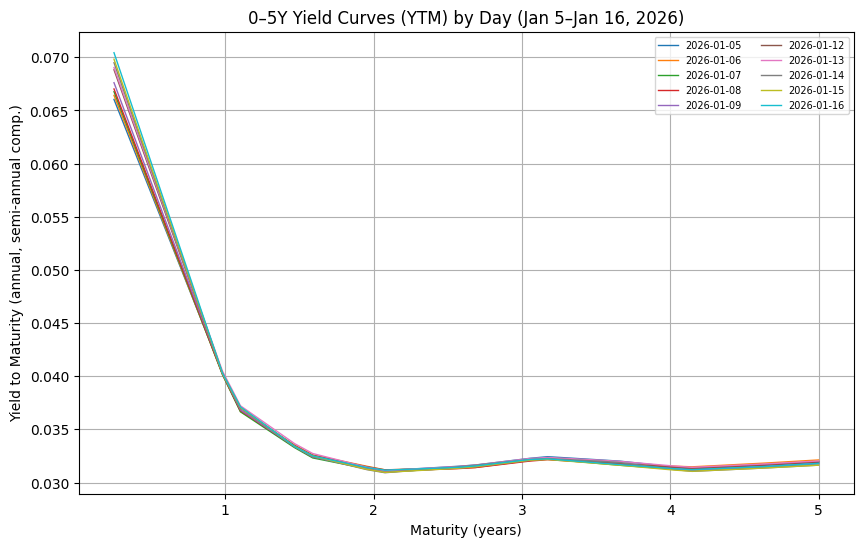

Saved: /content/Q4a_ytm_results.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d

FILE = FILE = "/content/ECO1856 A1 list.xlsx"
df = pd.read_excel(FILE)
ISIN_10 = ["CA135087R978","CA135087S547","CA135087T461","CA135087T958","CA135087Q491",
"CA135087Q988","CA135087R895","CA135087S471","CA135087T388","CA135087T792",]
df = df[df["ISIN"].isin(ISIN_10)].copy()
df["date"] = pd.to_datetime(df["date"])
df["Maturity Date"] = pd.to_datetime(df["Maturity Date"])
df["Price"] = df["Close Price (% of par)"].astype(float)
df["Coupon"] = df["Coupon"].astype(float)

def yearfrac_act365(d1, d2):
  return (d2 - d1).days / 365.0

def generate_semiannual_schedule(settle, maturity):
  dates = []
  d = maturity
  while d > settle:
    dates.append(d)
    d = d - pd.DateOffset(months=6)
  return sorted(dates)
def pv_from_ytm(settle, maturity, coupon_rate, ytm, par=100.0):
  c = par * coupon_rate / 2.0
  cf_dates = generate_semiannual_schedule(settle, maturity)
  pv = 0.0
  for d in cf_dates:
    t = yearfrac_act365(settle, d)
    disc = (1.0 + ytm/2.0) ** (-2.0 * t)
    cf = c
    if d == maturity:
      cf += par
    pv += cf * disc
  return pv
def solve_ytm(price, settle, maturity, coupon_rate, par=100.0):
  def f(y):
    return pv_from_ytm(settle, maturity, coupon_rate, y, par=par) - price
  lo, hi = -0.99, 2.00
  flo, fhi = f(lo), f(hi)
  if flo * fhi > 0:
    hi = 5.0
    fhi = f(hi)
    if flo * fhi > 0:
      raise ValueError("Root not bracketed. Check assumptions or data.")
  return brentq(f, lo, hi)

rows = []
for _, r in df.iterrows():
  ytm = solve_ytm(
    price=r["Price"],
    settle=r["date"],
    maturity=r["Maturity Date"],
    coupon_rate=r["Coupon"],
    par=100.0
  )
  ttm = yearfrac_act365(r["date"], r["Maturity Date"])
  rows.append({
    "date": r["date"],
    "ISIN": r["ISIN"],
    "Name": r["Name"],
    "coupon": r["Coupon"],
    "maturity": r["Maturity Date"],
    "ttm_years": ttm,
    "ytm": ytm
  })

ytm_df = pd.DataFrame(rows)
ytm_df.sort_values(["date","ttm_years"]).head(12)

grid = np.linspace(0.25, 5.0, 40)
plt.figure(figsize=(10, 6))
for d, sub in ytm_df.groupby("date"):
  sub = sub.sort_values("ttm_years")
  sub_use = sub[(sub["ttm_years"] > 0) & (sub["ttm_years"] <= 5.25)]
  x = sub_use["ttm_years"].to_numpy()
  y = sub_use["ytm"].to_numpy()
  f = interp1d(x, y, kind="linear", fill_value="extrapolate")
  plt.plot(grid, f(grid), linewidth=1, label=str(d.date()))
plt.xlabel("Maturity (years)")
plt.ylabel("Yield to Maturity (annual, semi-annual comp.)")
plt.title("0–5Y Yield Curves (YTM) by Day (Jan 5–Jan 16, 2026)")
plt.grid(True)
plt.legend(fontsize=7, ncol=2)
plt.show()
ytm_df.to_csv("/content/Q4a_ytm_results.csv", index=False)
print("Saved: /content/Q4a_ytm_results.csv")

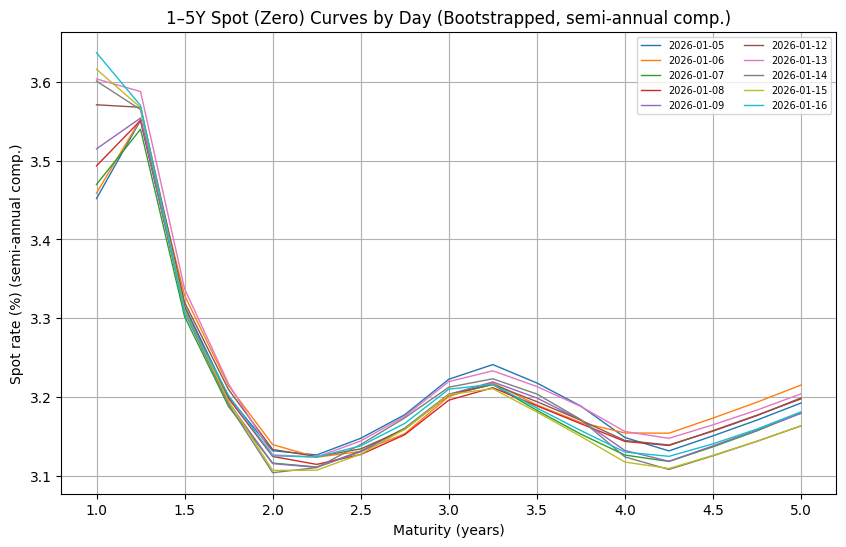

In [3]:
def parse_coupon_to_percent(x):
  if pd.isna(x):
    return np.nan
  if isinstance(x, str):
    x = x.strip().replace("%", "")
    return float(x)
  x = float(x)
  return x * 100.0 if x < 1.0 else x
df["coupon_pct"] = df["Coupon"].apply(parse_coupon_to_percent).astype(float)

def yearfrac_act365(d1, d2):
  return (d2 - d1).days / 365.0

def coupon_schedule(settle, maturity, freq=2):
  dates = []
  d = maturity
  step_months = int(12 / freq)
  while d > settle:
    dates.append(d)
    d = d - pd.DateOffset(months=step_months)
  return sorted(dates)

def bond_cashflows(settle, maturity, coupon_pct, freq=2, face=100.0):
  pay_dates = coupon_schedule(settle, maturity, freq=freq)
  if len(pay_dates) == 0:
    return pd.DataFrame({"pay_date": [], "t": [], "cf": []})
  cpn = (coupon_pct / 100.0) * face / freq
  cf = np.full(len(pay_dates), cpn, dtype=float)
  cf[-1] += face
  t = np.array([yearfrac_act365(settle, d) for d in pay_dates], dtype=float)
  out = pd.DataFrame({"pay_date": pay_dates, "t": t, "cf": cf})
  out = out[out["t"] > 0].copy()
  return out

def spot_from_D_semiannual(D, t, m=2):
  return m * (D ** (-1.0 / (m * t)) - 1.0)

def D_interp_factory():
  def D_interp(t_query, known_t, known_D):
    t_query = np.array(t_query, dtype=float)
    if len(known_t) == 0:
      return np.full_like(t_query, np.nan, dtype=float)
    known_t_arr = np.array(known_t, dtype=float)
    known_D_arr = np.array(known_D, dtype=float)
    order = np.argsort(known_t_arr)
    known_t_arr = known_t_arr[order]
    known_D_arr = known_D_arr[order]
    if len(known_t_arr) == 1:
      T1 = known_t_arr[0]
      D1 = known_D_arr[0]
      return D1 ** (t_query / T1)
    f_in = interp1d(known_t_arr, np.log(known_D_arr), kind="linear", fill_value="extrapolate")
    t_clamped = np.clip(t_query, known_t_arr.min(), known_t_arr.max())
    D_out = np.exp(f_in(t_clamped))
    idx_lo = t_query < known_t_arr.min()
    if np.any(idx_lo):
      T1 = known_t_arr[0]
      D1 = known_D_arr[0]
      D_out[idx_lo] = D1 ** (t_query[idx_lo] / T1)
    idx_hi = t_query > known_t_arr.max()
    if np.any(idx_hi):
      D_out[idx_hi] = np.exp(f_in(t_query[idx_hi]))
    return D_out
  return D_interp

D_interp = D_interp_factory()

freq = 2
face = 100.0
grid_1_5 = np.arange(1.00, 5.00 + 1e-9, 0.25)
spot_rows = []
curve_rows = []
plt.figure(figsize=(10, 6))

for day, day_df in df.groupby("date"):
  day_df = day_df.sort_values("Maturity Date").copy()
  known_t = []
  known_D = []
  for _, r in day_df.iterrows():
    settle = r["date"]
    maturity = r["Maturity Date"]
    price = float(r["Price"])
    coupon_pct = float(r["coupon_pct"])
    cfs = bond_cashflows(settle, maturity, coupon_pct, freq=freq, face=face)
    if cfs.empty:
      continue
    T = float(cfs["t"].max())
    cf_T = float(cfs.loc[np.isclose(cfs["t"], T), "cf"].sum())
    earlier = cfs[cfs["t"] < T].copy()
    pv_earlier = 0.0
    if len(earlier) > 0:
      D_earlier = D_interp(earlier["t"].to_numpy(), known_t, known_D)
      if np.all(np.isnan(D_earlier)):
        pv_earlier = 0.0
      else:
        pv_earlier = float(np.nansum(earlier["cf"].to_numpy() * D_earlier))
    residual = price - pv_earlier
    if residual <= 0 or cf_T <= 0:
      continue
    D_T = residual / cf_T
    if not (0 < D_T < 2.0):
      continue
    known_t.append(T)
    known_D.append(D_T)
  if len(known_t) < 2:
    continue
  order = np.argsort(np.array(known_t))
  known_t = list(np.array(known_t)[order])
  known_D = list(np.array(known_D)[order])
  known_t_arr = np.array(known_t, dtype=float)
  known_D_arr = np.array(known_D, dtype=float)
  known_spot = np.array([spot_from_D_semiannual(D, t, m=2) for D,
        t in zip(known_D_arr, known_t_arr)], dtype=float,)
  f_spot = interp1d(known_t_arr, known_spot, kind="linear", fill_value="extrapolate",)
  spot_grid = f_spot(grid_1_5)
  for t, s in zip(grid_1_5, spot_grid):
    curve_rows.append({"date": day, "t": float(t),"spot_semiannual": float(s),})
  for t, D, s in zip(known_t_arr, known_D_arr, known_spot):
    spot_rows.append({"date": day,"ttm_years": float(t),"DF": float(D),"spot_semiannual": float(s),})
  plt.plot(grid_1_5, 100.0 * spot_grid, linewidth=1, label=str(day.date()),)

plt.title("1–5Y Spot (Zero) Curves by Day (Bootstrapped, semi-annual comp.)")
plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%) (semi-annual comp.)")
plt.grid(True)
plt.legend(fontsize=7, ncol=2)
plt.show()
spot_raw_df = (pd.DataFrame(spot_rows).sort_values(["date", "ttm_years"]))
spot_curve_df = (pd.DataFrame(curve_rows).sort_values(["date", "t"]))
spot_raw_df.to_csv("/content/Q4b_spot_raw_nodes.csv", index=False)
spot_curve_df.to_csv("/content/Q4b_spot_results.csv", index=False)


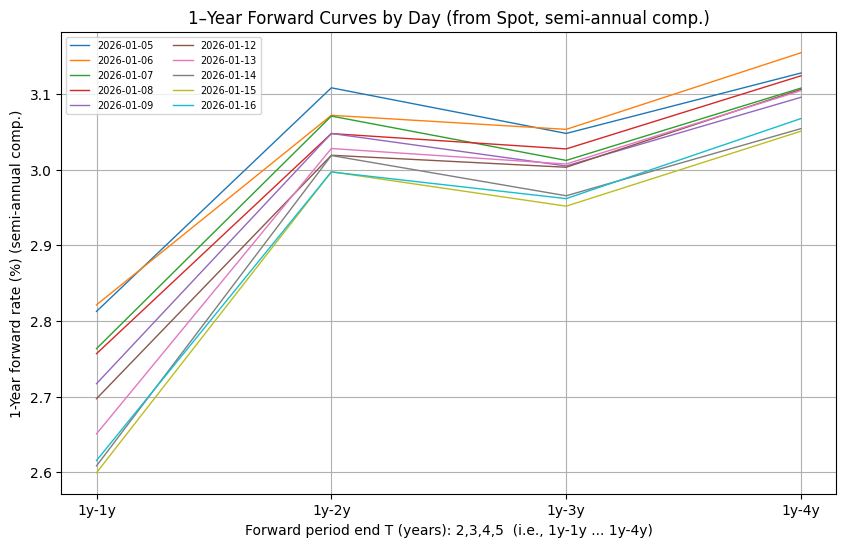

In [4]:
SPOT_FILE="/content/Q4b_spot_results.csv"
spot_df=pd.read_csv(SPOT_FILE)
spot_df["date"]=pd.to_datetime(spot_df["date"])
spot_df["t"]=spot_df["t"].astype(float)
spot_df["spot_semiannual"]=spot_df["spot_semiannual"].astype(float)
spot_df=spot_df.sort_values(["date","t"]).reset_index(drop=True)

def DF_from_spot_semiannual(s,t):
  return 1.0/(1.0+s/2.0)**(2.0*t)

def forward_1y_from_DF(DF_1,DF_T,T):
  n=T-1.0
  return 2.0*((DF_1/DF_T)**(1.0/(2.0*n))-1.0)
T_list=[2.0,3.0,4.0,5.0]
labels={2.0:"1y-1y",3.0:"1y-2y",4.0:"1y-3y",5.0:"1y-4y"}
rows=[]
plt.figure(figsize=(10,6))
for day,sub in spot_df.groupby("date"):
  sub=sub.sort_values("t").copy()
  t_nodes=sub["t"].to_numpy()
  s_nodes=sub["spot_semiannual"].to_numpy()
  f_spot=interp1d(t_nodes,s_nodes,kind="linear",fill_value="extrapolate")
  S={T:float(f_spot(T)) for T in [1.0,2.0,3.0,4.0,5.0]}
  DF={T:DF_from_spot_semiannual(S[T],T) for T in [1.0,2.0,3.0,4.0,5.0]}
  fwd_vals=[]
  for T in T_list:
    fwd=forward_1y_from_DF(DF[1.0],DF[T],T)
    fwd_vals.append(fwd)
    rows.append({"date":day, "forward_start_year":1.0,"forward_end_year":float(T),
          "forward_label":labels[T], "fwd_1y_semiannual":float(fwd)})
  plt.plot(T_list,100.0*np.array(fwd_vals),linewidth=1,label=str(day.date()))

plt.title("1–Year Forward Curves by Day (from Spot, semi-annual comp.)")
plt.xlabel("Forward period end T (years): 2,3,4,5  (i.e., 1y-1y ... 1y-4y)")
plt.ylabel("1-Year forward rate (%) (semi-annual comp.)")
plt.xticks(T_list,["1y-1y","1y-2y","1y-3y","1y-4y"])
plt.grid(True)
plt.legend(fontsize=7,ncol=2)
plt.show()

fwd_df=pd.DataFrame(rows).sort_values(["date","forward_end_year"]).reset_index(drop=True)
fwd_df.to_csv("/content/Q4c_forward_results.csv",index=False)


In [7]:
YTM_FILE="/content/Q4a_ytm_results.csv"
FWD_FILE="/content/Q4c_forward_results.csv"

ytm_df=pd.read_csv(YTM_FILE)
fwd_df=pd.read_csv(FWD_FILE)

ytm_df["date"]=pd.to_datetime(ytm_df["date"])
fwd_df["date"]=pd.to_datetime(fwd_df["date"])

ytm_df["ttm_years"]=ytm_df["ttm_years"].astype(float)
ytm_df["ytm"]=ytm_df["ytm"].astype(float)

fwd_df["forward_label"]=fwd_df["forward_label"].astype(str)
fwd_df["fwd_1y_semiannual"]=fwd_df["fwd_1y_semiannual"].astype(float)

ytm_df=ytm_df.sort_values(["date","ttm_years"]).reset_index(drop=True)
fwd_df=fwd_df.sort_values(["date","forward_label"]).reset_index(drop=True)

tenors=[1.0,2.0,3.0,4.0,5.0]
yield_rows=[]

for day,sub in ytm_df.groupby("date"):
    sub=sub.sort_values("ttm_years")
    x=sub["ttm_years"].to_numpy()
    y=sub["ytm"].to_numpy()
    f=interp1d(x,y,kind="linear",fill_value="extrapolate")
    row={"date":day}
    for T in tenors:
        row[f"y{int(T)}"]=float(f(T))
    yield_rows.append(row)

yields_daily=pd.DataFrame(yield_rows).sort_values("date").reset_index(drop=True)

wanted_labels=["1y-1y","1y-2y","1y-3y","1y-4y"]

forward_daily=fwd_df.pivot(index="date",columns="forward_label",values="fwd_1y_semiannual").reset_index()

missing=[c for c in wanted_labels if c not in forward_daily.columns]
if missing:
    raise ValueError(f"Missing forward_label columns: {missing}. Available: {list(forward_daily.columns)}")

forward_daily=forward_daily[["date"]+wanted_labels].sort_values("date").reset_index(drop=True)

def log_returns(df,cols):
    df=df.sort_values("date").reset_index(drop=True)
    R=df[cols].to_numpy(dtype=float)
    if np.any(R<=0):
        bad=np.where(R<=0)
        raise ValueError(f"Non-positive rates found; cannot take log. Positions: {bad}")
    X=np.log(R[1:,:]/R[:-1,:])
    return pd.DataFrame(X,columns=[f"X_{c}" for c in cols])

yield_cols=["y1","y2","y3","y4","y5"]
fwd_cols=wanted_labels

X_yield=log_returns(yields_daily,yield_cols)
X_fwd=log_returns(forward_daily,fwd_cols)

cov_yield=X_yield.cov().values
cov_fwd=X_fwd.cov().values

cov_yield_df=pd.DataFrame(cov_yield,index=[f"X_y{i}" for i in range(1,6)],columns=[f"X_y{i}" for i in range(1,6)])
cov_fwd_df=pd.DataFrame(cov_fwd,index=[f"X_f{i}" for i in range(1,5)],columns=[f"X_f{i}" for i in range(1,5)])

cov_yield_df.to_csv("/content/Q5_cov_yield.csv")
cov_fwd_df.to_csv("/content/Q5_cov_forward.csv")

np.set_printoptions(precision=2,suppress=False,formatter={"float_kind":lambda x:f"{x:.2e}"})

print("\nYield log-return covariance matrix (5x5):")
print(cov_yield)

print("\nForward log-return covariance matrix (4x4):")
print(cov_fwd)



Yield log-return covariance matrix (5x5):
[[6.84e-06 5.45e-06 6.01e-06 1.07e-05 1.01e-05]
 [5.45e-06 2.53e-05 -2.27e-06 2.49e-05 3.47e-05]
 [6.01e-06 -2.27e-06 1.20e-05 2.32e-06 -3.37e-06]
 [1.07e-05 2.49e-05 2.32e-06 3.25e-05 4.02e-05]
 [1.01e-05 3.47e-05 -3.37e-06 4.02e-05 5.46e-05]]

Forward log-return covariance matrix (4x4):
[[9.16e-05 -2.67e-05 4.91e-05 7.28e-05]
 [-2.67e-05 2.59e-05 -1.07e-05 -2.38e-05]
 [4.91e-05 -1.07e-05 5.11e-05 6.24e-05]
 [7.28e-05 -2.38e-05 6.24e-05 8.40e-05]]


In [8]:
Sigma_yield=pd.read_csv("/content/Q5_cov_yield.csv",index_col=0).values
Sigma_fwd=pd.read_csv("/content/Q5_cov_forward.csv",index_col=0).values

eigval_y,eigvec_y=np.linalg.eigh(Sigma_yield)
eigval_f,eigvec_f=np.linalg.eigh(Sigma_fwd)

idx_y=np.argsort(eigval_y)[::-1]
idx_f=np.argsort(eigval_f)[::-1]

eigval_y=eigval_y[idx_y]
eigvec_y=eigvec_y[:,idx_y]

eigval_f=eigval_f[idx_f]
eigvec_f=eigvec_f[:,idx_f]

Lambda_yield=np.diag(eigval_y)
Lambda_fwd=np.diag(eigval_f)

np.set_printoptions(precision=4,suppress=False)

print("\nΛ_yield =")
print(Lambda_yield)

print("\nV_yield =")
print(eigvec_y)

print("\nΛ_fwd =")
print(Lambda_fwd)

print("\nV_fwd =")
print(eigvec_f)
total_var_y=eigval_y.sum()
total_var_f=eigval_f.sum()

varshare_y=eigval_y/total_var_y
varshare_f=eigval_f/total_var_f

print("\n--- Variance explained (Yield) ---")
print("Total variance (trace) =",total_var_y)
print("Largest eigenvalue λ1 =",eigval_y[0])
print("Share explained by PC1 =",varshare_y[0])
print("All shares =",varshare_y)

print("\n--- Variance explained (Forward) ---")
print("Total variance (trace) =",total_var_f)
print("Largest eigenvalue λ1 =",eigval_f[0])
print("Share explained by PC1 =",varshare_f[0])
print("All shares =",varshare_f)

yield_var_table=pd.DataFrame({
    "PC":[f"PC{i}" for i in range(1,len(eigval_y)+1)],
    "eigenvalue":eigval_y,
    "var_share":varshare_y
})

fwd_var_table=pd.DataFrame({
    "PC":[f"PC{i}" for i in range(1,len(eigval_f)+1)],
    "eigenvalue":eigval_f,
    "var_share":varshare_f
})

print("\nYield variance table:")
print(yield_var_table)

print("\nForward variance table:")
print(fwd_var_table)




Λ_yield =
[[1.0969e-04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.7354e-05 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 3.1293e-06 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 6.1244e-07 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.2149e-07]]

V_yield =
[[-0.1472 -0.4722  0.2313  0.8125  0.2041]
 [-0.454   0.1735 -0.8146  0.285  -0.1373]
 [ 0.013  -0.8137 -0.3582 -0.4163  0.1898]
 [-0.5307 -0.2449  0.3166 -0.1445 -0.7329]
 [-0.7002  0.1573  0.233  -0.2538  0.6052]]

Λ_fwd =
[[2.0916e-04 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 2.7323e-05 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.5173e-05 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 9.3237e-07]]

V_fwd =
[[-0.6149  0.5124 -0.5924 -0.0916]
 [ 0.1959 -0.5854 -0.7476  0.2451]
 [-0.4482 -0.5566  0.091  -0.6936]
 [-0.6186 -0.2915  0.2861  0.6712]]

--- Variance explained (Yield) ---
Total variance (trace) = 0.00013121001764671903
Largest eigenvalue λ1 = 0.0001096927492